In [1]:
import numba
from random import randint
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import timeit
import time
from collections import Counter
from mpl_toolkits import mplot3d
%matplotlib inline

In [2]:
'''
This function will run each individual trial of the Birthday Paradox problem.
'''
def runBDPTrial(n):
    # make an empty list and initialize the count
    sample_list = []
    count = 0

    # keep looping until successful return call
    while(True):
        # generate random int between 0, n
        x = randint(1, n)
        
        # increment the count of randomly generated numbers
        count = count + 1
        
        # if x is already in sample list return the count
        if x in sample_list:
            return count
        # else add x to the list
        else:
            sample_list.append(x)
    return

# optimize with numba
runBDPTrial_nb = numba.jit(runBDPTrial)

In [3]:
'''
This function will run each individual trial of the Coupon Collectors problem.
'''
def runCCTrial(n):
    # make an empty list and initialize the count
    sample_set = set()
    count = 0
    
    # keep looping until successful return call
    while(len(sample_set) < n):
        # generate random int between 0, n
        x = randint(1, n)
        
        # increment the count of randomly generated numbers
        count = count + 1
        
        # add the random number to the set
        sample_set.add(x)

    return count

# optimize with numba
runCCTrial_nb = numba.jit(runCCTrial)

In [4]:
'''
This function conducts the entire Birthday Paradox simulation.
'''
def repeatTrial(n, m, trial_function):
    # initialize an empty list
    full_list = []
    
    # run m individual trials and append results
    # to the full_list
    i = 0
    for i in range(m):
        full_list.append(trial_function(n))

    return full_list

repeatTrial_nb = numba.jit(repeatTrial)

In [5]:
'''
This function takes a list of values and derives the PDF.
The PDF is then returned in a dictionary structure.
'''
def probabilityDensityFunction(arg_list):
    # convert list to dictionary
    # with keys being the list elements
    # and values being the count of element appearnces in list
    result_count = Counter(arg_list)
    
    # get the total number of observations
    total = sum(result_count.values(), 0.0)
    
    # divide each value in dictionary by total
    regularized_count = {k: v / total for k, v in result_count.items()}
    
    return regularized_count

In [6]:
'''
This function takes a PDF dictionary and returns
an ordered Pandas DataFrame with an additional 
column for cumulative probabilities.
'''
def cdfDataFrame(prob_dic):
    # converting the dicitonary to a 2 column numpy array
    df = np.array([[k,v] for k,v in prob_dic.items()])
    
    # sort the 2 column array for values in column 0
    df = df[df[:, 0].argsort()]
    
    # calculate the cumulative sum of the second column
    cdf = np.cumsum(df[:, 1])
    
    # now make a pandas dataframe
    data = pd.DataFrame({'Values': df[:, 0],
                         'Probability': df[:, 1],
                         'Cumulative Probability': cdf})
    
    return data

In [7]:
'''
This function plots the CDF DataFrame.
'''
def plotCDF(cdf_df, title):
    plt.figure(figsize = (10,10))
    
    # generate a plot
    plt.plot(cdf_df['Values'],
             cdf_df['Cumulative Probability'], 'r', lw=2.0)
    
    # grid lines on
    plt.grid(True)

    # adding some labels for clarity
    plt.xlabel("Number of Trials Until Success")
    plt.ylabel("% of Successful Experiments")
    plt.title(title)
    
    return

In [8]:
'''
This function takes a list and returns its expected value.
'''
def expectedValue(arg_list):
    return sum(arg_list) / len(arg_list)
    

In [9]:
# compute simulation time
def timeSimulation(n, m, repitions, trial_name):
    
    SETUP_CODE = '''
from __main__ import {}
from __main__ import repeatTrial_nb
from random import randint'''.format(trial_name)
    
    TEST_CODE = '''
repeatTrial_nb(n = {}, m = {}, trial_function = {})'''.format(n, m, trial_name)
    
    # running the code 100 times
    simulation_time = timeit.timeit(setup = SETUP_CODE,
                        stmt = TEST_CODE,
                        number = repitions)
    # taking average
    simulation_time = simulation_time / repitions
    
    return simulation_time

In [10]:
def runAllSimulations(domain_size, number_of_trials, n_scaler, m_scaler, trial_name):
    # making the list to store the combination of results
    # each row will be an appended dictionary
    result_list = []
    
    # making refernce variables for the m loop for clarity purposes
    m_start = int(number_of_trials / m_scaler)
    m_end = number_of_trials + 1
    
    # making reference variables of the n loop for clarity purposes
    n_start = int(domain_size / n_scaler)
    n_end = domain_size + 1
    
    # run all simulations
    for m in range(m_start, m_end, m_start):
        for n in range(n_start, n_end, n_start):
            t = timeSimulation(n, m, 1, trial_name)
            tmp_dic = {'domain_size': n, 'number_of_trials': m, 'time':t}
            result_list.append(tmp_dic)
            
    # make the dataframe from list of dictionaries
    res_df = pd.DataFrame(result_list)
    return res_df

In [24]:
'''
This function takes a results dataframe and plots the 3D surface visualization.
'''
def plotSurface(df, title):
    
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection = '3d')
    x = df['domain_size'].to_numpy()
    y = df['number_of_trials'].to_numpy()
    z = df['time'].to_numpy()
    x_lim = np.max(x)
    ax.plot_trisurf(x, y, z,
                    cmap = 'YlOrRd', edgecolor = 'none')
    ax.set_xlabel("Domain Size")
    ax.set_ylabel("Number of Trials")
    ax.set_zlabel("Time in Seconds")
    ax.set_xlim(x_lim, 0)
    ax.set_title(title)
    
    return

In [29]:
# call each simulation's base case
print("Result of Birthday Paradox Simulation with n=5,000: ", runBDPTrial_nb(5000), " trials.");
print("Result of the Coupon Collectors Simulation with n=300: ", runCCTrial_nb(300), " trials.");

Result of Birthday Paradox Simulation with n=5,000:  75  trials.
Result of the Coupon Collectors Simulation with n=300:  1707  trials.


In [13]:
# repeat each type of simulation m times
bdp_trials = repeatTrial_nb(n = 5000, m = 300, trial_function = runBDPTrial_nb)
cc_trials = repeatTrial_nb(n = 300, m = 400, trial_function = runCCTrial_nb)

In [14]:
print("Birthday Paradox Expected Value: ", expectedValue(bdp_trials))
print("Coupon Collectors Expected Value: ", expectedValue(cc_trials))

Birthday Paradox Expected Value:  83.56
Coupon Collectors Expected Value:  1896.2375


In [15]:
# get the pdf
bdp_pdf = probabilityDensityFunction(bdp_trials)
cc_pdf = probabilityDensityFunction(cc_trials)

In [16]:
# get the cdf dataframe
bdp_cdf_df = cdfDataFrame(bdp_pdf)
cc_cdf_df = cdfDataFrame(cc_pdf)

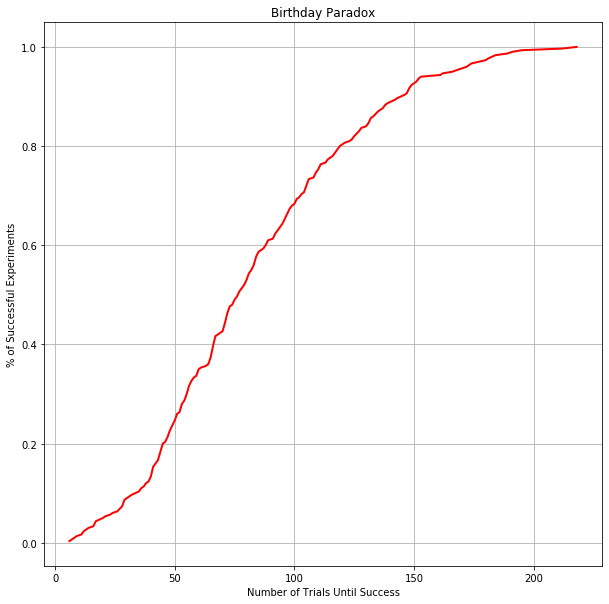

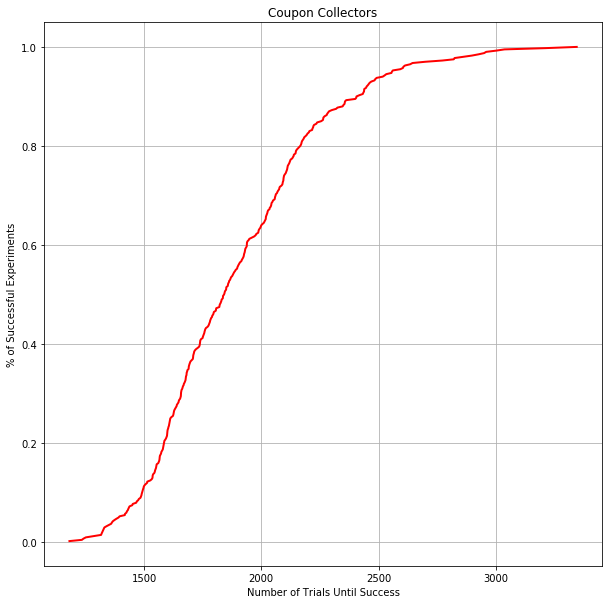

In [17]:
# view the data
plotCDF(bdp_cdf_df, "Birthday Paradox")
plotCDF(cc_cdf_df, "Coupon Collectors")

In [18]:
# should be about 200 combinations
print("Beginning Birthday Paradox Simulation...")
bdp_t0 = time.time()
bdp_df = runAllSimulations(domain_size = 1000000, number_of_trials = 10000, n_scaler = 20, m_scaler = 10, trial_name = "runBDPTrial_nb")
bdp_t1 = time.time()
bdp_t = (bdp_t1 - bdp_t0) / 60
print("First Simulation complete in {} minutes...\n".format(bdp_t))

bdp_df.to_csv("BirthDayParadox_times.csv")

# should be about 200 combinations
print("Beginning Coupon Collectors Simulation...")
cc_t0 = time.time()
cc_df = runAllSimulations(domain_size = 20000, number_of_trials = 5000, n_scaler = 20, m_scaler = 10, trial_name = "runCCTrial_nb")
cc_t1 = time.time()
cc_t = (cc_t1 - cc_t0) / 60
print("Second Simulation complete in {} minutes...\n".format(cc_t))

cc_df.to_csv("Coupon Collectors_times.csv")

Beginning Birthday Paradox Simulation...
First Simulation complete in 5.015010778109232 minutes...

Beginning Coupon Collectors Simulation...
Second Simulation complete in 27.549778242905933 minutes...



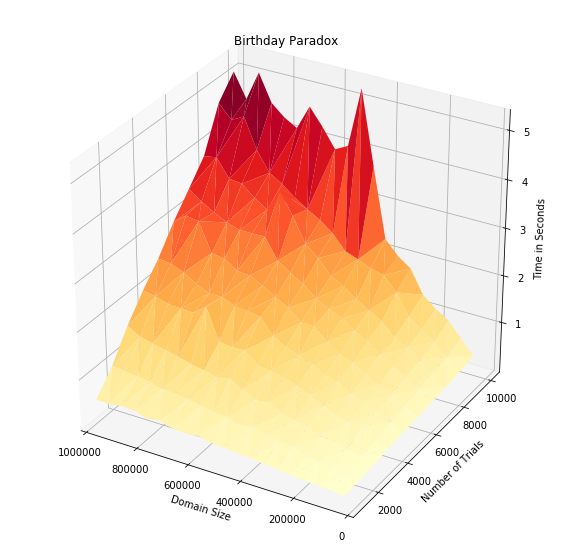

In [25]:
plotSurface(bdp_df, "Birthday Paradox")

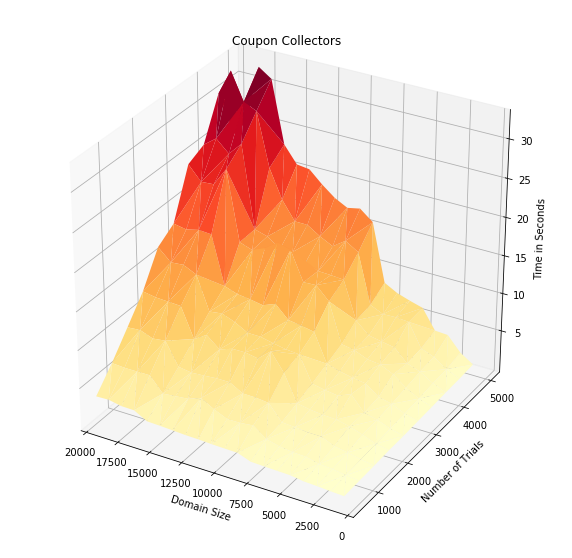

In [26]:
plotSurface(cc_df, "Coupon Collectors")

In [21]:
bdp_df.head(10)

,domain_size,number_of_trials,time
0,50000,1000,0.030794
1,100000,1000,0.061488
2,150000,1000,0.078854
3,200000,1000,0.095359
4,250000,1000,0.121065
5,300000,1000,0.149793
6,350000,1000,0.175692
7,400000,1000,0.208776
8,450000,1000,0.228193
9,500000,1000,0.252291


In [23]:
%timeit repeatTrial_nb(n = 5000, m = 300, trial_function = runBDPTrial_nb)

1.47 ms ± 42.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [30]:
%timeit repeatTrial_nb(n = 300, m = 400, trial_function = runCCTrial_nb)

20.5 ms ± 1.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [33]:
import math

math.pow(2,2)

4.0

In [36]:
import operator as op
from functools import reduce

def ncr(n, r):
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer / denom

In [40]:
ncr(23,2)

253.0

In [67]:
no_col = 4999/5000

1 - math.pow(no_col, ncr(83,2))

0.49372134974982607

In [82]:
i = 0
int_sum = 0
for i in range(1, 300, 1):
    this_sum = 1 / i
    int_sum += this_sum

In [83]:
300 * int_sum

1883.7991640898508